The notebook contains examples on how to load spikes from .npy files. Loaded spikes are stored in .csv file (all units from all mice).

It plots some summary information about the dataset. The plot is saved in the figures google drive folder.

In [5]:
import numpy as np
import pandas as pd
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

#### Parameters

In [2]:
# your path to the dataset
dataset_folder = Path('D:/bernstein/dataset_py/')

#### Helper functions

In [3]:
def load_mouse_data(mouse_id: int, dataset_folder: Path, verbose: bool = True):
    """
    Load spikes, cluster IDs, and brain areas for a given mouse folder.

    Parameters
    ----------
    mouse_id : int
        Identifier of the mouse (folder name).
    dataset_folder : Path
        Root dataset folder.
    verbose : bool
        If True, print dataset shapes/info.

    Returns
    -------
    dict
        key is cluster_id, value is { 'spikes': [...], 'brain_area': int}
    """
    mouse_folder = dataset_folder / str(mouse_id)
    if verbose:
        print(f"Loading mouse {mouse_id} from {mouse_folder}")

    # file paths
    brain_areas_file = mouse_folder / "brain_area.npy"
    cluster_ids_file = mouse_folder / "clusters.npy"
    spikes_file = mouse_folder / "spikes.npy"

    # load arrays
    brain_areas = np.load(brain_areas_file, allow_pickle=True).item()
    cluster_ids = np.load(cluster_ids_file)
    spikes = np.load(spikes_file)

    if verbose:
        print(f"brain_areas keys: {list(brain_areas.keys())}")
        print(f"brain_area cluster_id shape: {brain_areas['cluster_id'].shape}")
        print(f"brain_area names shape: {brain_areas['brain_area'].shape}")
        print(f"cluster_ids shape: {cluster_ids.shape}, "
              f"unique clusters: {len(np.unique(cluster_ids))}")
        print(f"spikes shape: {spikes.shape}")

    # build brain area map
    brain_area_map = dict(zip(brain_areas["cluster_id"], brain_areas["brain_area"]))

    # organize spikes per cluster
    cluster_data = {}
    for cid, spike in zip(cluster_ids, spikes):
        cluster_data.setdefault(cid, {"spikes": [], "brain_area": brain_area_map[cid]})
        cluster_data[cid]["spikes"].append(spike)

    return cluster_data


def load_all_mice(dataset_folder: str | Path, n_mice: int = 18, verbose: bool = True):
    """
    Load spikes for all mice.

    Returns
    -------
    dict
        key is mouse_id (folder name), value is cluster_data
    """
    dataset_folder = Path(dataset_folder)
    all_data = {}
    for mouse_id in range(1, n_mice + 1):
        all_data[mouse_id] = load_mouse_data(mouse_id, dataset_folder, verbose=verbose)
    return all_data


def export_spikes_to_csv(spikes_dataset_dict: dict, dataset_folder: str | Path, filename: str = "output/full_dataset.csv") -> Path:
    """
    Export spikes dataset dict to a CSV file.

    Parameters
    ----------
    spikes_dataset_dict : dict
        key is mouse_id (folder name), value is cluster_data.
    dataset_folder : str | Path
        Root dataset folder where the CSV will be saved.
    filename : str, default="output/full_dataset.csv"
        Relative path of the CSV file inside dataset_folder.

    Returns
    -------
    Path
        Path to the created CSV file.
    """
    dataset_folder = Path(dataset_folder)
    csv_path = dataset_folder / filename
    csv_path.parent.mkdir(parents=True, exist_ok=True) 

    with open(csv_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["mouse_id", "cluster_id", "brain_area", "rec_len_sec", "spikes"])

        for mouse_id, clusters in spikes_dataset_dict.items():
            for cluster_id, data in clusters.items():
                spikes = data["spikes"]
                if not spikes:  # skip empty
                    continue
                rec_len_sec = spikes[-1]
                writer.writerow([
                    mouse_id,
                    cluster_id,
                    data["brain_area"],
                    rec_len_sec,
                    ";".join(map(str, spikes))
                ])

    print(f"CSV file '{csv_path}' has been created successfully!")
    return csv_path

#### Loading spikes

In [6]:
spikes_dataset_dict = load_all_mice(dataset_folder, n_mice=18, verbose=False)
export_spikes_to_csv(spikes_dataset_dict, dataset_folder, "output/full_dataset.csv")

CSV file 'D:\bernstein\dataset_py\output\full_dataset.csv' has been created successfully!


WindowsPath('D:/bernstein/dataset_py/output/full_dataset.csv')

#### Ploting summary info

total units count 1449


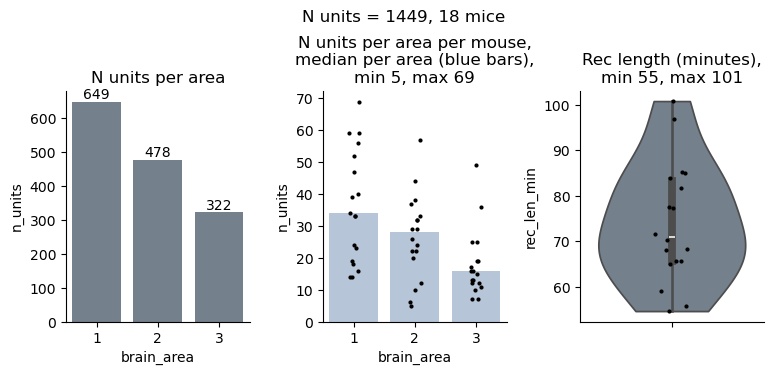

In [7]:
csv_filename = dataset_folder / "output/full_dataset.csv"
df = pd.read_csv(csv_filename, usecols=["mouse_id", "cluster_id", "brain_area", "rec_len_sec"])

# units per brain area
units_per_brain_area = (
    df.groupby("brain_area")["cluster_id"].count().reset_index(name="n_units")
)
mice_per_brain_area = (
    df.groupby("brain_area")["mouse_id"].nunique().reset_index(name="n_mice")
)
units_per_brain_area = pd.merge(units_per_brain_area, mice_per_brain_area, on="brain_area")
print(f"total units count {units_per_brain_area['n_units'].sum()}")

# units per area per mouse
units_per_brain_area_per_mouse = (
    df.groupby(["brain_area", "mouse_id"])["cluster_id"].count().reset_index(name="n_units")
)

# recording length per mouse 
rec_len_per_mouse = df.groupby("mouse_id")["rec_len_sec"].max().reset_index()
rec_len_per_mouse["rec_len_min"] = rec_len_per_mouse["rec_len_sec"] / 60

# plotting 
color = "slategrey"
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

# panel 0
sns.barplot(ax=axes[0], x="brain_area", y="n_units", data=units_per_brain_area, color=color)
axes[0].bar_label(axes[0].containers[0], fmt="%.0f")
axes[0].set_title("N units per area")

# panel 1
sns.stripplot(ax=axes[1], x="brain_area", y="n_units", data=units_per_brain_area_per_mouse,
              color="black", s=3)
median_units = (
    units_per_brain_area_per_mouse.groupby("brain_area")["n_units"].median()
    .apply(np.ceil).astype(int).reset_index()
)
sns.barplot(ax=axes[1], x="brain_area", y="n_units", data=median_units, color="lightsteelblue")
axes[1].set_title(
    f"N units per area per mouse,\n"
    f"median per area (blue bars),\n"
    f"min {units_per_brain_area_per_mouse['n_units'].min()}, "
    f"max {units_per_brain_area_per_mouse['n_units'].max()}"
)

# panel 2
sns.violinplot(ax=axes[2], y="rec_len_min", data=rec_len_per_mouse,
               cut=0, density_norm="width", color=color)
sns.stripplot(ax=axes[2], y="rec_len_min", data=rec_len_per_mouse, color="black", s=3)
axes[2].set_title(
    f"Rec length (minutes),\n"
    f"min {rec_len_per_mouse['rec_len_min'].min():.0f}, "
    f"max {rec_len_per_mouse['rec_len_min'].max():.0f}"
)

fig.suptitle(
    f"N units = {units_per_brain_area['n_units'].sum()}, "
    f"{df['mouse_id'].nunique()} mice", y=1.15
)
sns.despine()
fig.savefig(dataset_folder / "output/spikes_info.png", bbox_inches="tight")